# Solving SAT With Grover
In this notebook, we aim to solve satisfyability formulae using grover search.
For this, we first construct marking oracles for the basic gates of AND, OR and NOT.
Then, we transform them into the required phase-oracle-form.

The main resources used are this [Microsoft Kata](https://github.com/microsoft/QuantumKatas/blob/ec925ccfcb599a6bb29c8a39035d0b149f447f9a/SolveSATWithGrover/Workbook_SolveSATWithGrover.ipynb) and this [Qiskit Textbook Chapter](https://qiskit.org/textbook/ch-applications/satisfiability-grover.html).

## Marking Oracles
### And

In [1]:
from qiskit.circuit import Qubit, QuantumRegister, AncillaRegister, QuantumCircuit, Gate, ClassicalRegister
from qiskit.quantum_info import Operator

from typing import Dict, List, Tuple

import numpy as np
import math
np.set_printoptions(threshold=1e6)


def create_and_oracle(inp_reg: QuantumRegister, tar: Qubit) -> QuantumCircuit:
    """
        Constructs an oracle for boolean AND,
        that is a multi-controlled X gate
    """
    tar_reg = QuantumRegister(bits=[tar])
    qc = QuantumCircuit(inp_reg, tar_reg)

    qc.mcx(inp_reg, tar_reg)

    return qc

### Or

In [2]:
def create_or_oracle(inp_reg: QuantumRegister, tar: Qubit) -> QuantumCircuit:
    """
        Constructs an oracle for boolean OR,
        from NOT (X) and AND oracles
    """
    tar_reg = QuantumRegister(bits=[tar])
    qc = QuantumCircuit(inp_reg, tar_reg)

    # Negate all inputs
    for i in inp_reg:
        qc.x(i)
    
    # Call AND oracle
    and_oracle = create_and_oracle(inp_reg, tar).to_gate(label="$U_{and}$")
    qc.append(and_oracle, inp_reg[:]+tar_reg[:])

    # Inverse negation
    for i in inp_reg:
        # Inverse of x is x
        qc.x(i)

    # Flip target
    qc.x(tar_reg[0])
    
    return qc

While we could go on further and create _XOR_ and _AlternatingBits_ oracles but we don't need them for now so let's not :)

## SAT Marking Oracles
Using our marking gate-oracles, we can create oracles for evaluating SAT clauses and finally complete functions.

### Single Clause Oracle
A Clause is a disjunction of variables (qubits) that are potentially negated.
The clause `x0 || !x1` may be represented by the input `[(0, true), (1, false)]`.

In [3]:
def get_clause_qubits(inp_reg: QuantumRegister, clause: List[Tuple[int, bool]]) -> List[Qubit]:
    """
        Return a register containing only relevant qubits for a SAT clause
    """

    clause_qubits:list(Qubit) = []

    for index, _ in clause:
        clause_qubits.append(inp_reg[index])

    return clause_qubits

def create_clause_oracle(inp_reg: QuantumRegister, tar: Qubit, clause: List[Tuple[int, bool]]) -> QuantumCircuit:
    """
        Create an oracle for a SAT clause
    """
    tar_reg = QuantumRegister(bits=[tar], name="q_tar")
    qc = QuantumCircuit(inp_reg, tar_reg)

    # Flip all qubits which are negated in the clause
    for index, positive in clause:
        if not positive:
            qc.x(index)
    
    
    # Get Clause Qubits
    clause_qubits = get_clause_qubits(inp_reg, clause)
    clause_reg = QuantumRegister(bits=clause_qubits)

    # Create an OR oracle for clause
    clause_oracle = create_or_oracle(clause_reg, tar).to_gate(label="$U_{or}$")
    qc.append(clause_oracle, clause_reg[:]+tar_reg[:])

    # Inverse the initial flips
    for index, positive in clause:
        if not positive:
            qc.x(index)

    return qc

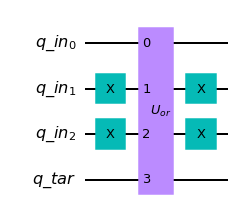

In [4]:
# Debug Clause Oracle
inp_reg = QuantumRegister(3, name="q_in")
tar = Qubit()
tar_reg = QuantumRegister(bits=[tar])
clause = [(0, True),(1, False),(2,False)]

clause_circuit = create_clause_oracle(inp_reg, tar, clause)
clause_circuit.draw(output="mpl")

### k-SAT Oracle
Using our single clause oracle, we can take their conjunction and create a marking oracle for the entire expression.

In [5]:
def create_ksat_oracle(inp_reg: QuantumRegister, tar: Qubit, clauses: List[List[Tuple[int, bool]]]) -> Gate:
    """
        Create an Oracle for a kSAT problem
    """
    ancilla_reg = AncillaRegister(len(clauses), name="a")
    tar_reg = QuantumRegister(bits=[tar], name="q_tar")
    qc = QuantumCircuit(inp_reg, tar_reg, ancilla_reg)

    # Compose individual clauses
    for index, clause in enumerate(clauses):
        # Use one ancilla for each clause
        clause_oracle = create_clause_oracle(inp_reg, ancilla_reg[index], clause).to_gate(label="$U_{clause}$")
        qc.append(clause_oracle, inp_reg[:]+[ancilla_reg[index]])
    
    # Store the conjugate transpose (inverse) for later qubit cleanup
    inverse_qc = qc.inverse()
    
    # Use and oracle onto ancilla register and target
    and_oracle = create_and_oracle(ancilla_reg, tar).to_gate(label="$U_{and}$")
    qc.append(and_oracle, ancilla_reg[:]+tar_reg[:])

    # Inverse clause oracles
    qc = qc.compose(inverse_qc)

    return qc

**DONE** We can now formulate a SAT problem and create a marking oracle for it!

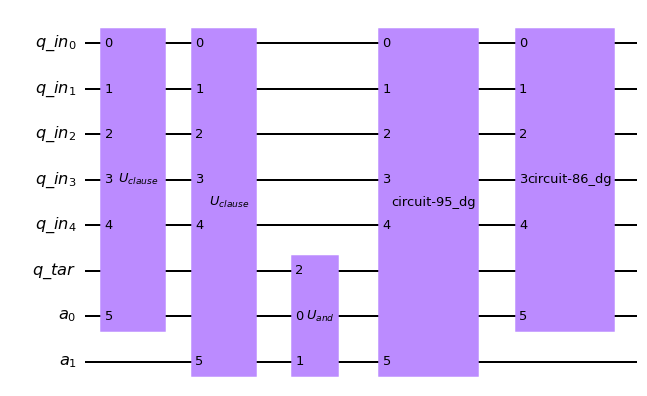

In [6]:
# f(x) = (B + !D + E) * (A + !C)
# g(x) = (!A+!C)(!B+C)
problem_f = [[(1, True),(3, False),(4, True)],
          [(0, True),(2, False)]]

problem_g = [[(0, False)], [(1, True), (2, True)]]

problem = np.array(problem_f, dtype=object)
n_variables = 5

inp_reg = QuantumRegister(n_variables, name="q_in")
tar = Qubit()
tar_reg = QuantumRegister(bits=[tar])

problem_circuit = create_ksat_oracle(inp_reg, tar, problem)
problem_circuit.draw(output="mpl", justify="left")

## Converting the oracles into phase oracles for Grover

In [7]:
def oracle_converter(oracle_qc: QuantumCircuit, target_idx: int) -> QuantumCircuit:
    """
        Convert a bit-flip into a phase oracle
    """
    phase_qc = oracle_qc.copy()

    qc_conv = QuantumCircuit(1, name="$U_{phase}$")
    qc_conv.x(0)
    qc_conv.h(0)
    # Prepend the phase transformation
    phase_qc = phase_qc.compose(qc_conv, qubits=[target_idx], front=True)
    # Append the phase transformation 
    phase_qc = phase_qc.compose(qc_conv.inverse(), qubits=[target_idx])

    return phase_qc

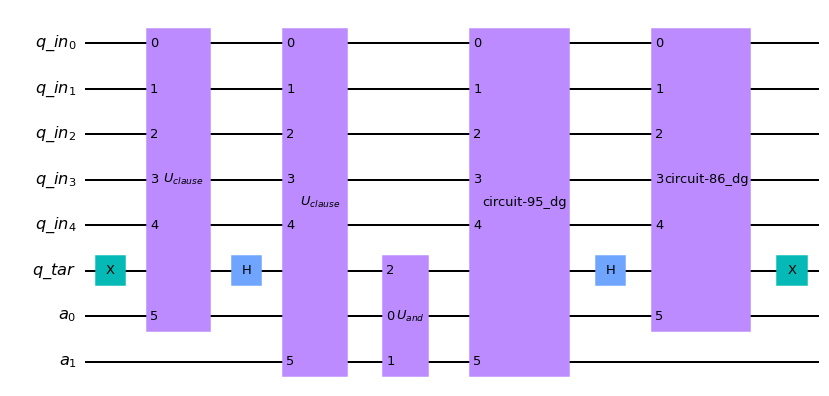

In [8]:
phase_problem_circuit = oracle_converter(problem_circuit, len(inp_reg))
phase_problem_circuit.draw(output="mpl")

### Analyzing Oracles

In [9]:
def print_matrix(circuit):
    """
        Prints the matrix of a given quantum circuit (oracle) and analyzes it regarding positive and negative values
    """
    ppod = Operator(circuit).data
    print("Values in Operator", set(ppod.flatten()))
    print(f"Oracle Shape: {ppod.shape}", f"Elements;; nonzero:{np.count_nonzero(ppod)}, 1: {np.count_nonzero(ppod.real > 0.99)}, -1: {np.count_nonzero(ppod.real < -0.99)}")
    print("Diagonal values: ", [round(ppod[x][x].real) for x in range(len(ppod[0]))])
    print(ppod)
    
# print_matrix(phase_problem_circuit)

In [10]:
def print_diagonal_analysis(circuit, measurements=None):
    """
        Prints analysis data about a given quantum circuit (oracle).
        This method was used to determine whether one could trivially derive valid states from a given oracle.
        
        Keyword Arguments"
        circuit -- qiskit quantum circuit representing a grover oracle
        measurements -- dictionary of states and measurement counts as derived by qiskits counts() method after simulation
    """
    od = Operator(circuit).data
    diagonal_values = [round(od[x][x].real) for x in range(len(od[0]))]
    bspace_padding = math.ceil(math.log(len(diagonal_values), 2))
    
    if measurements is not None:
        measurement_threshold = max(measurements.values()) / (2**2)
        measurements = {key:val for key, val in measurements.items() if val > measurement_threshold}
    
    for i, v in enumerate(diagonal_values):
        vs = " 1" if  v == 1 else "-1"
        state_str = format(i, f"0{bspace_padding}b")
        
        # when measurements are available, check if a phase flipped state may be good
        state_marking = ""
        if measurements is not None and v == -1:
            if list(filter(state_str.endswith, measurements.keys())) != []:
                state_marking = "good"
            else:
                input_size = len(list(measurements)[0])
                ancilla_State = int(state_str[:-input_size])
                if ancilla_State == 0:
                    state_marking = "!AMBIGUOUS!"
                else:
                    state_marking = "invalid"
        
        print(vs, state_str, state_marking)
        
count_dummy = {'01010': 1, '11000': 2, '11011': 7, '00011': 1, '01111': 3, '00010': 8, '00101': 4, '10101': 5, '01011': 6, '00001': 8, '11010': 5, '10010': 10, '00000': 1, '01001': 87, '10000': 6, '11001': 4, '11111': 2, '10110': 89, '11101': 3, '00110': 75, '11110': 87, '10111': 5, '01101': 79, '01110': 87, '10011': 7, '00100': 78, '01100': 78, '10001': 3, '01000': 91, '11100': 72, '00111': 4, '10100': 82}
# print_diagonal_analysis(phase_problem_circuit, count_dummy)

# Plugging Oracles into Grover
As we can now create phase oracles, we can model a complete grover loop.

1. Create uniform superposition over q_in (an & target stay |0>)
2. Make oracle: ksat_for_problem(...) & phase_oracle(...)
3. Grover Loop (k-times? correctness-check?)
    1. Append Phase_Oracle over all q registers
    2. Append Grover Diffuser over all q registers
3. Add classical registers for output measurements
5. Measure q_in into classical registers and check solution (histogram)

In [11]:
# Input:
# f(x) = (x0 + !x1) * (!x2 + !x3) * (x2 + x3) * (!x4 + x5) # Poster Problem
#problem = [[(0, True), (1, True)], [(2, False), (3, False)], [(2, True), (3, True)], [(4, False), (5, True)]]
# n_variables = 6

(1.) Create uniform superposition

In [12]:
def initialize_s(qc, qubits):
    """
        Apply a H-gate to 'qubits' in qc
    """
    for q in qubits:
        qc.h(q)
    return qc

(2.) Make oracle for specific sat problem

In [13]:
def init_sat_circuit(problem):
    """
        Returns calculated number of qubits, created circuit
    """

    # Number of input qubits
    num_vars = len(set([statement[0] for clause in problem for statement in clause]))
    # Number of ancialla qubits
    num_clauses = len(problem)
    num_qubits = num_vars + num_clauses + 1

    # Init registers and qubits
    inp_reg = QuantumRegister(num_vars, name="q_in")
    tar = Qubit()
    tar_reg = QuantumRegister(bits=[tar], name="q_tar")
    ancilla_reg = AncillaRegister(num_clauses, name="a")

    # Create oracle for this SAT problem instance
    qc_oracle = QuantumCircuit(num_qubits)
    qc_oracle.append(create_ksat_oracle(inp_reg, tar, problem).to_gate(label="$U_{ksat}$"), qc_oracle.qubits)
    qc_phase_oracle = oracle_converter(qc_oracle, len(inp_reg))

    # Construct main quantum circuit
    c_regs = ClassicalRegister(num_vars, 'c')
    main_qc = QuantumCircuit(inp_reg, tar_reg, ancilla_reg, c_regs)

    # Create uniform superposition
    main_qc = initialize_s(main_qc, range(num_vars))

    return (num_vars, num_qubits, main_qc, qc_oracle, qc_phase_oracle)

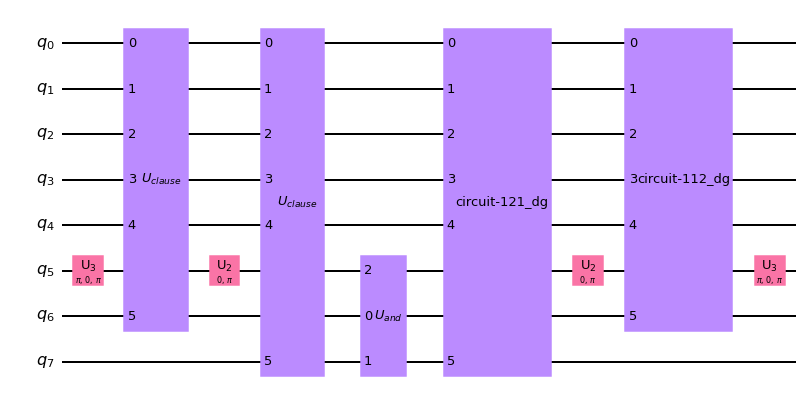

In [14]:
_, _, _, _, qc_phase_oracle = init_sat_circuit(problem)
qc_phase_oracle_decomposed = qc_phase_oracle.decompose() # .decompose().decompose().decompose()
qc_phase_oracle_decomposed.draw(output="mpl", justify="left")


(3.) Grover Loop

In [15]:
def create_ksat_grover(problem: List[List[Tuple[int, bool]]], k) -> Tuple[QuantumCircuit, QuantumCircuit]:
    """
        Creates an circuit for the SAT problem instance and applies Grover k times
    """

    # Init sat circuit
    num_inp_qubits, num_qubits, main_qc, qc_oracle, qc_phase_oracle = init_sat_circuit(problem)

    # Add grover diffuser
    from grover import diffuser
    diff = diffuser(num_inp_qubits)

    # Grover loop: add the oracle and diffusor step k times
    phase_oracle_gate = qc_phase_oracle.to_gate(label='U$_{oracle}$')
    register_map = list(range(num_inp_qubits))
    for i in range(k):
        main_qc.append(phase_oracle_gate, range(num_qubits))
        main_qc = main_qc.compose(diff, register_map)
        
    # Add measurements of input qubits
    main_qc.measure(register_map, register_map)
#     main_qc.measure_all()
    
    return (main_qc, qc_phase_oracle)

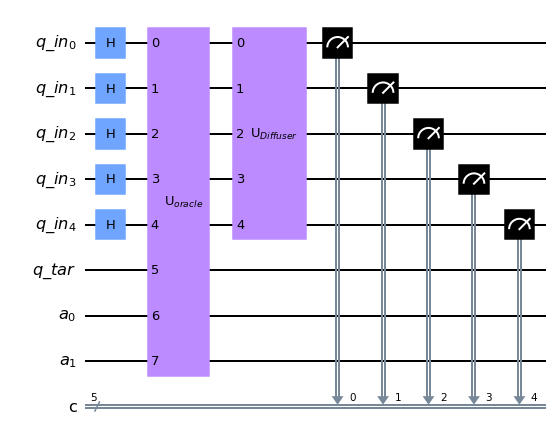

In [16]:
# A suitable k could be calculated using quantum phase estimation
k=1

# Create the circuit
main_qc, qc_oracle = create_ksat_grover(problem, k)


main_qc.draw(output="mpl", justify="left")

The Quantum Circuit is completed! Simulate it!

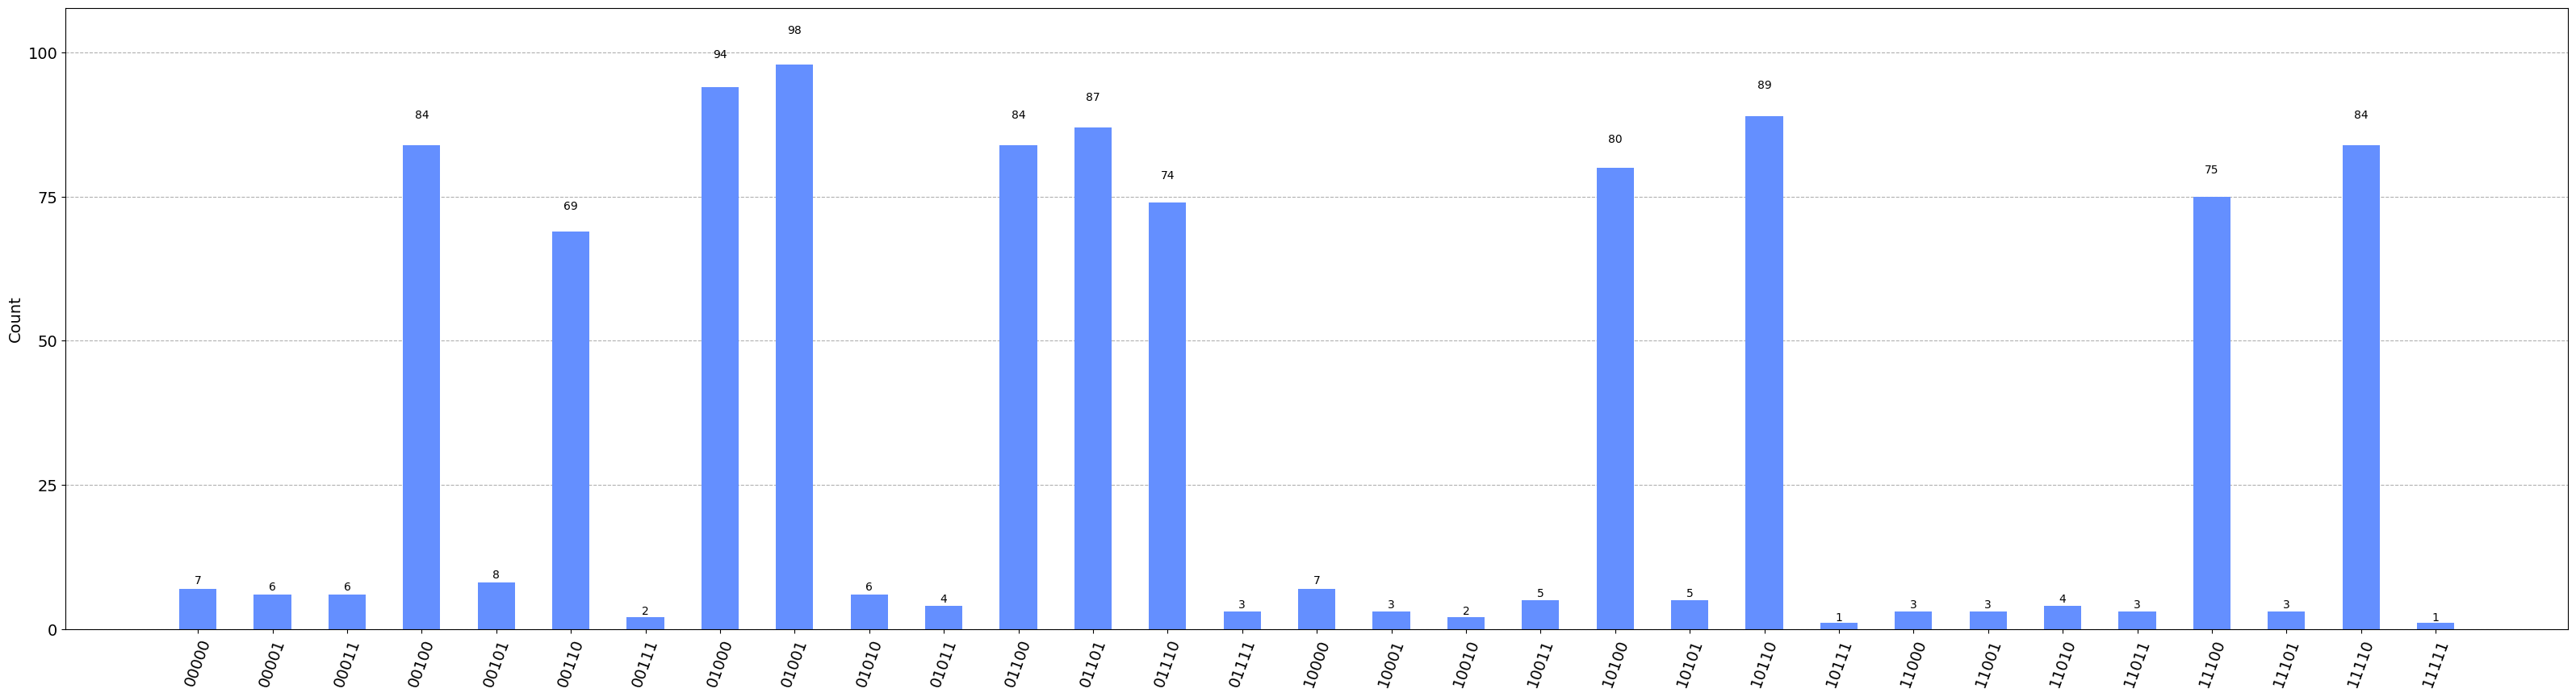

In [17]:
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import StatevectorSimulator

transpiled_grover_circuit = transpile(main_qc, StatevectorSimulator())
results = StatevectorSimulator().run(transpiled_grover_circuit, shots=1000).result()
counts = results.get_counts()
histogram = plot_histogram(counts, figsize=(40, 10))
histogram # For display purposes in jupyter

## Warmstarting other Quantum circuits
If we want to use this result to warmstart other quantum circuits, we need the list of complex amplitudes of that statevector!

In [18]:
# Get the statevector from counts.
def calc_statevector_from(counts, width=None):
    threshold = max(counts.values())/1e2 # one order of magnitude below the most often measured results
    count_vector = []
    shots = 0 # measured shots
    
    # derive width from counts if not given
    if width is None:
        width = len(list(counts.keys()))
    
    # create statevector by using counts
    for i in range(2**width):
        b = format(i, f"0{width}b")
        c = counts.get(b)
        # print(i, b, c)
        if c is None:
            count_vector.append(0)
        else:
            count_vector.append(c)
            shots += c
    
    # normalize vector
    count_arr = np.array(count_vector)
    norm_vector = count_arr / count_arr.sum()
    
    # sqrt vector
    statevector = np.sqrt(norm_vector)
    return statevector

This function can be used to calculate a statevector from a set of measurements!
Now double check that this vector yields the same result

array([0.05477226, 0.05477226, 0.07071068, 0.05477226, 0.3       ,
       0.06324555, 0.28284271, 0.07745967, 0.30331502, 0.29832868,
       0.03162278, 0.05477226, 0.2236068 , 0.28284271, 0.27386128,
       0.06324555, 0.04472136, 0.06324555, 0.04472136, 0.07071068,
       0.31304952, 0.05477226, 0.3082207 , 0.07071068, 0.07071068,
       0.08944272, 0.04472136, 0.07745967, 0.29325757, 0.06324555,
       0.28635642, 0.07071068])


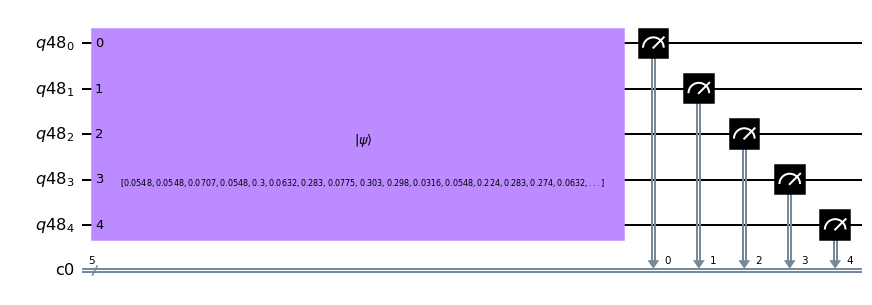

In [19]:
num_vars = n_variables # restrict to n qubits defined near the problems because we don't care about our ancillas
manual_statevector = calc_statevector_from(counts, num_vars)
print(repr(manual_statevector))

qc_vec = QuantumCircuit(QuantumRegister(num_vars), ClassicalRegister(num_vars))
qc_vec.initialize(manual_statevector)
qc_vec.measure(list(range(num_vars)), list(range(num_vars)))
qc_vec.draw(output="mpl")

Circuit Depth: 2


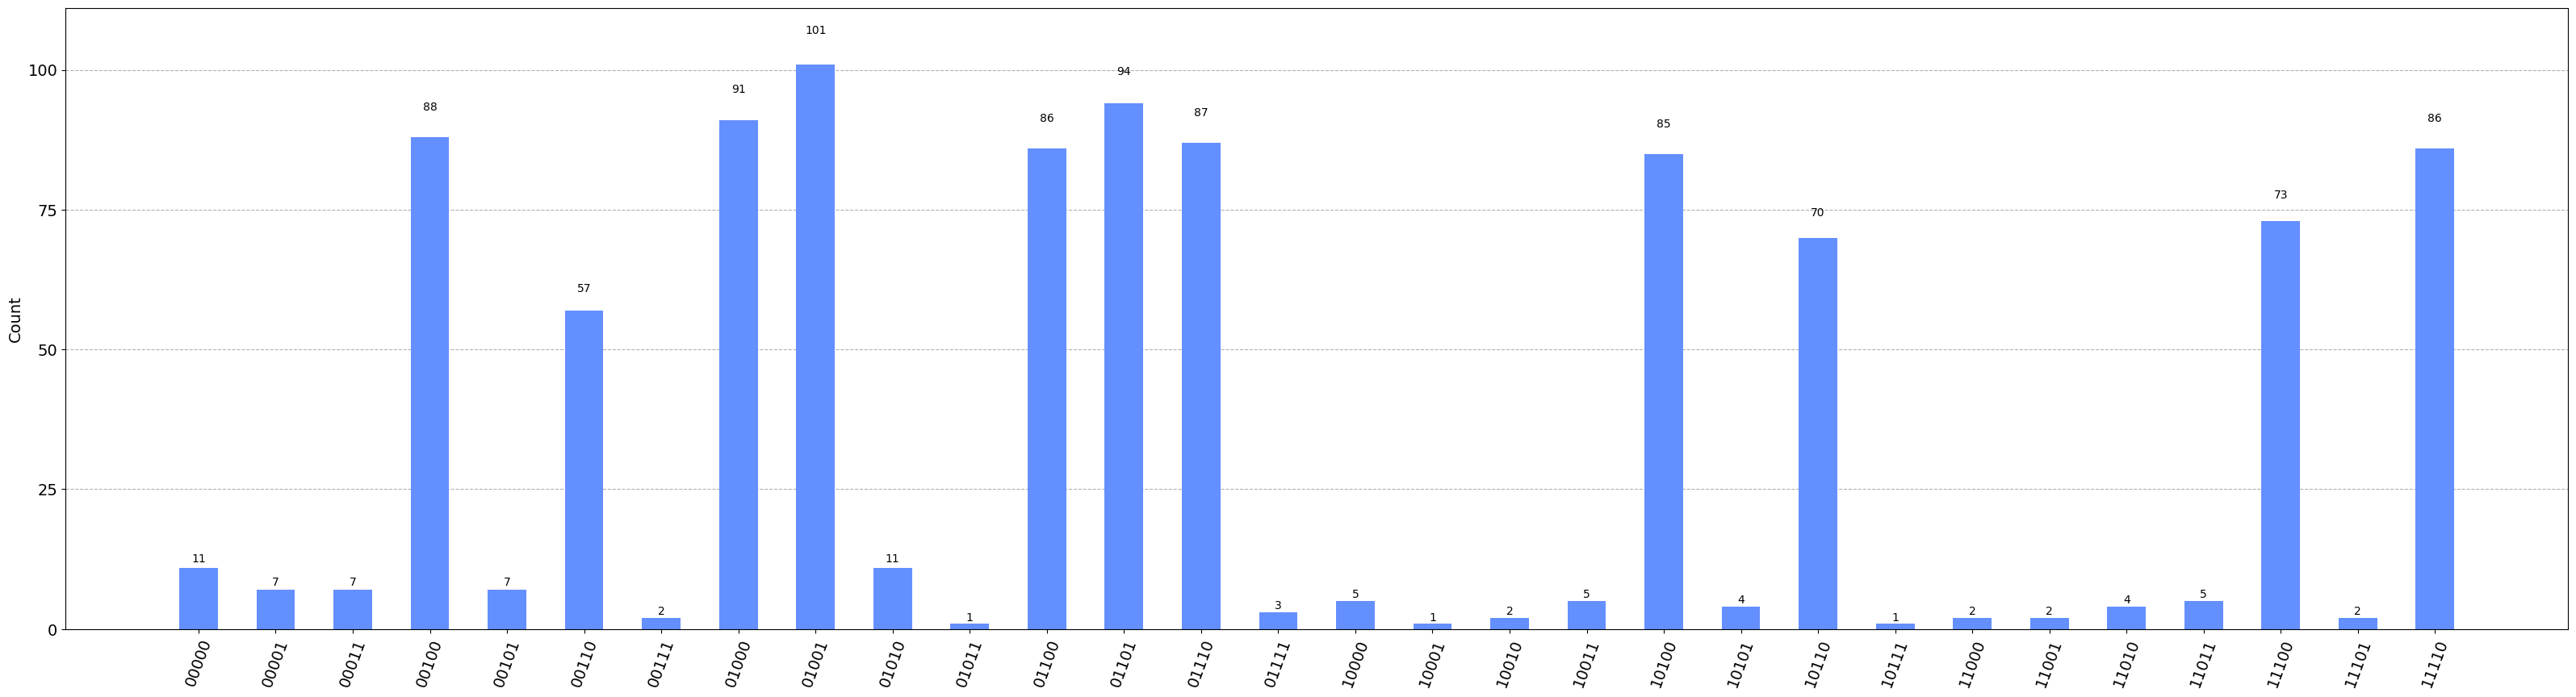

In [20]:
transpiled_vec_circuit = transpile(qc_vec, StatevectorSimulator())
print(f"Circuit Depth: {transpiled_vec_circuit.depth()}")
results = StatevectorSimulator().run(transpiled_vec_circuit, shots=1000).result()
counts = results.get_counts()
histogram = plot_histogram(counts, figsize=(40, 10))
histogram # For display purposes in jupyter

# Importing Feature Models

In [21]:
from qiskit import Aer, transpile
from util.xml_reader import Extended_Modelreader
from util.dimacs_reader import DimacsReader
from util.cnf import CNF
import os 

def create_grover_for_model(rel_path, k=1):
    # load given model
    current_folder = globals()['_dh'][0]
    some_model_path = os.path.join(current_folder, rel_path)
    
    if rel_path.split('.')[-1] == "xml":
        reader = Extended_Modelreader()
        feature_model, constraints = reader.readModel(some_model_path)
        # transform to cnf and then to problem
        feature_cnf = feature_model.build_cnf(constraints)
        print(feature_cnf)
        problem = feature_cnf.to_problem()
    
    elif rel_path.split('.')[-1] in ["dimacs", "cnf"]:
        rd = DimacsReader()
        rd.fromFile(some_model_path)
        problem = CNF().from_dimacs(rd).to_problem()
    
    # create grover circuit
    problem_qc, problem_oracle = create_ksat_grover(problem, k) # Create the circuit
    return problem_qc
    
model = "../benchmarks/featureide-examples/car.dimacs"
# model = "../benchmarks/problem_f.cnf"
model_circuit = create_grover_for_model(model, k=5)
# model_circuit.draw(output="mpl")


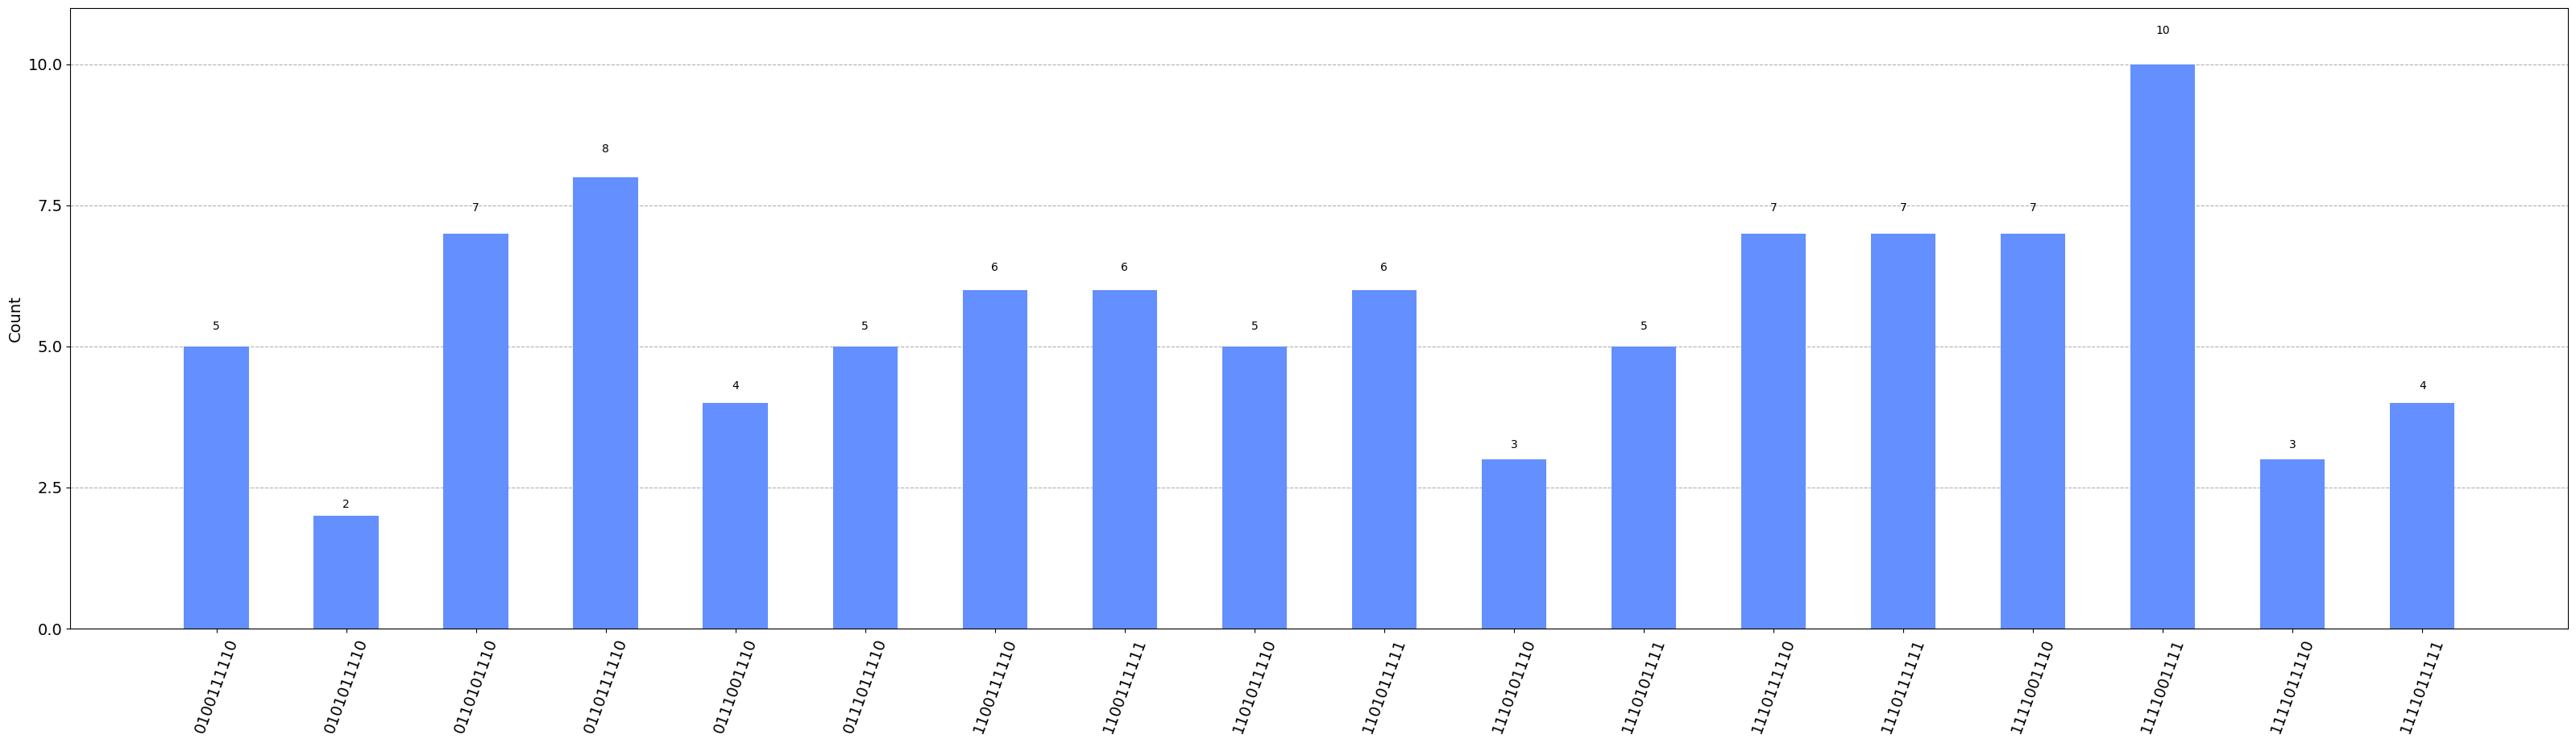

In [22]:
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator

    
def collect_circuit_info(circuit, backend="aer_simulator", shots=100, simulate=False):
    # transpile and collect meta data
    info = {}
    simulator = Aer.get_backend(backend)
    transpiled_grover_circuit = transpile(circuit, backend=simulator)
    info['depth'] = transpiled_grover_circuit.depth()
    info['width'] = transpiled_grover_circuit.num_qubits
    
    # try to run/simulate
    if simulate:
        results = simulator.run(transpiled_grover_circuit, shots=shots).result()
        info['counts'] = results.get_counts()
    
    return info

# gather backend metrics
# from qiskit import IBMQ, assemble, transpile
# provider = IBMQ.load_account()

# print(provider.backends())
# simulate_circuit(model_circuit, provider.backend.ibmq_geneva)    

# actual simulation
info = collect_circuit_info(model_circuit, shots=100, simulate=True)
plot_histogram(info['counts'], figsize=(40, 10))